In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.inspection import permutation_importance


sns.set(style="whitegrid")

In [ ]:
# ---- Loading in the data -----
df_train = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_add.xlsx')
df_val = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data_add.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data_add.xlsx')


In [ ]:
df_train = df_train.dropna(subset=['return_t'])
df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])

<ipython-input-6-fe7202b4425a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trading_day'] = pd.to_datetime(df_train['trading_day'])


In [ ]:
base_features = ['return_t', 'Volume', 'VIX']
sentiment_features = ['IWSS_Equal', 'IWSS_Ratio', 'IWSS_Impurity', 'IWSS_perm',
                      'IWSS_SHAP', 'IWSS_metric', 'IWSS_PCA', 'Sentiment_score']
all_features = base_features + sentiment_features
target = 'return_t+1'

In [ ]:
# Evaluation function
def evaluate_rf_model(name, X_train, y_train, X_val, y_val,
                      param_grid=None, search_type='grid', n_iter=10, random_state=42):

    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 300],
            'max_depth': [3, 5, 10],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4, 6],
            'max_features': ['sqrt', 0.5]
        }

    # Save feature names before scaling
    feature_names = X_val.columns.tolist()

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Base model
    base_model = RandomForestRegressor(random_state=random_state)

    # Tune hyperparameters using validation set
    if search_type == 'grid':
        search = GridSearchCV(base_model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    else:
        search = RandomizedSearchCV(base_model, param_grid, n_iter=n_iter, scoring='neg_mean_squared_error', cv=3, random_state=random_state, n_jobs=-1)

    # Training
    search.fit(X_train_scaled, y_train)
    best_model = search.best_estimator_
    best_params = search.best_params_

    # Predictions
    y_pred_train = best_model.predict(X_train_scaled)
    y_pred_val = best_model.predict(X_val_scaled)


     # --- Train metrics ---
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_pred_train)
    train_correct = (np.sign(y_pred_train) == np.sign(y_train)).sum()
    train_accuracy = train_correct / len(y_train)

    # --- Validation metrics ---
    val_mse = mean_squared_error(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, y_pred_val)
    train_mean = np.mean(y_train)
    roos = 1 - np.sum((y_val - y_pred_val) ** 2) / np.sum((y_val - train_mean) ** 2)
    val_correct = (np.sign(y_pred_val) == np.sign(y_val)).sum()
    val_accuracy = val_correct / len(y_val)

    # Store results
    results.append({
        'Model': name,
        **best_params,

        # Train
        'Train R²': train_r2,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Train RMSE': train_rmse,
        'Train Directional Accuracy (%)': train_accuracy * 100,
        'Train Correct': train_correct,
        'Train Total': len(y_train),

        # Validation
        'Val R²': val_r2,
        'ROOS': roos,
        'Val MSE': val_mse,
        'Val MAE': val_mae,
        'Val RMSE': val_rmse,
        'Val Directional Accuracy (%)': val_accuracy * 100,
        'Val Correct Predictions': val_correct,
        'Validation Total': len(y_val)
    })

    return best_model, scaler


In [ ]:
models = {}
scalers = {}
results = []

# Feature groups
base_features = ['return_t', 'Volume', 'VIX']
sentiment_features = [
    'IWSS_Equal', 'IWSS_Ratio', 'IWSS_Impurity', 'IWSS_perm',
    'IWSS_SHAP', 'IWSS_metric', 'IWSS_PCA', 'Sentiment_score'
]
target = 'return_t+1'

# Validation targets
y_train = df_train[target]
y_val = df_val[target]

# --- Base Model ---
models['Base'], scalers['Base'] = evaluate_rf_model(
    'Base',
    df_train[base_features],
    y_train,
    df_val[base_features],
    y_val,
    param_grid=None,       # Optional: define hyperparam grid
    search_type='grid'
)

# --- Base + Sentiment_score ---
models['Base + Sentiment_score'], scalers['Base + Sentiment_score'] = evaluate_rf_model(
    'Base + Sentiment_score',
    df_train[base_features + ['Sentiment_score']],
    y_train,
    df_val[base_features + ['Sentiment_score']],
    y_val,
    param_grid=None,
    search_type='grid'
)

# --- Base + IWSS_* Models ---
for feat in sentiment_features:
    if feat == 'Sentiment_score':
        continue
    model_name = f'Base + {feat}'
    models[model_name], scalers[model_name] = evaluate_rf_model(
        model_name,
        df_train[base_features + [feat]],
        y_train,
        df_val[base_features + [feat]],
        y_val,
        param_grid=None,
        search_type='grid'
    )

In [ ]:
results_rf = pd.DataFrame(results)
results_rf

,Model,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Train R²,Train MSE,Train MAE,Train RMSE,...,Train Correct,Train Total,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Val Directional Accuracy (%),Val Correct Predictions,Validation Total
0,Base,3,sqrt,4,10,100,0.079511,0.000147,0.009252,0.012113,...,302,459,-0.086427,-0.019759,0.000053,0.005575,0.007278,45.578231,67,147
1,Base + Sentiment_score,3,sqrt,6,5,50,0.102825,0.000143,0.009139,0.011959,...,289,459,-0.207379,-0.133289,0.000059,0.006030,0.007673,44.217687,65,147
2,Base + IWSS_Equal,3,sqrt,4,5,100,0.091836,0.000145,0.009188,0.012032,...,297,459,-0.084443,-0.017896,0.000053,0.005582,0.007272,45.578231,67,147
3,Base + IWSS_Ratio,3,sqrt,6,5,100,0.088039,0.000145,0.009179,0.012057,...,296,459,-0.081908,-0.015517,0.000053,0.005569,0.007263,48.979592,72,147
4,Base + IWSS_Impurity,3,sqrt,4,5,100,0.092082,0.000145,0.009169,0.012030,...,298,459,-0.084521,-0.017970,0.000053,0.005570,0.007272,47.619048,70,147
5,Base + IWSS_perm,3,sqrt,4,5,100,0.090981,0.000145,0.009192,0.012038,...,291,459,-0.085834,-0.019202,0.000053,0.005582,0.007276,44.897959,66,147
6,Base + IWSS_SHAP,3,sqrt,6,5,50,0.084005,0.000146,0.009214,0.012084,...,303,459,-0.095701,-0.028464,0.000053,0.005611,0.007309,46.258503,68,147
7,Base + IWSS_metric,3,sqrt,6,5,50,0.094487,0.000144,0.009164,0.012014,...,292,459,-0.104192,-0.036434,0.000054,0.005631,0.007337,44.897959,66,147
8,Base + IWSS_PCA,3,sqrt,6,5,50,0.097335,0.000144,0.009148,0.011995,...,296,459,-0.092280,-0.025253,0.000053,0.005606,0.007298,44.217687,65,147


In [ ]:
results_rf = pd.DataFrame(results)
results_rf

,Model,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Train R²,Train MSE,Train MAE,Train RMSE,...,Train Correct,Train Total,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Val Directional Accuracy (%),Val Correct Predictions,Validation Total
0,Base,3,sqrt,4,10,100,0.079511,0.000147,0.009252,0.012113,...,302,459,-0.086427,-0.019759,0.000053,0.005575,0.007278,45.578231,67,147
1,Base + Sentiment_score,3,sqrt,6,5,50,0.102825,0.000143,0.009139,0.011959,...,289,459,-0.207379,-0.133289,0.000059,0.006030,0.007673,44.217687,65,147
2,Base + IWSS_Equal,3,sqrt,4,5,100,0.091836,0.000145,0.009188,0.012032,...,297,459,-0.084443,-0.017896,0.000053,0.005582,0.007272,45.578231,67,147
3,Base + IWSS_Ratio,3,sqrt,6,5,100,0.088039,0.000145,0.009179,0.012057,...,296,459,-0.081908,-0.015517,0.000053,0.005569,0.007263,48.979592,72,147
4,Base + IWSS_Impurity,3,sqrt,4,5,100,0.092082,0.000145,0.009169,0.012030,...,298,459,-0.084521,-0.017970,0.000053,0.005570,0.007272,47.619048,70,147
5,Base + IWSS_perm,3,sqrt,4,5,100,0.090981,0.000145,0.009192,0.012038,...,291,459,-0.085834,-0.019202,0.000053,0.005582,0.007276,44.897959,66,147
6,Base + IWSS_SHAP,3,sqrt,6,5,50,0.084005,0.000146,0.009214,0.012084,...,303,459,-0.095701,-0.028464,0.000053,0.005611,0.007309,46.258503,68,147
7,Base + IWSS_metric,3,sqrt,6,5,50,0.094487,0.000144,0.009164,0.012014,...,292,459,-0.104192,-0.036434,0.000054,0.005631,0.007337,44.897959,66,147
8,Base + IWSS_PCA,3,sqrt,6,5,50,0.097335,0.000144,0.009148,0.011995,...,296,459,-0.092280,-0.025253,0.000053,0.005606,0.007298,44.217687,65,147


if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7],
            'min_samples_split': [5, 10],         
            'min_samples_leaf': [3, 5, 7],      
            'max_features': ['sqrt', 0.5]
        }


cv = 5

In [ ]:
results_rf = pd.DataFrame(results)
results_rf

,Model,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Train R²,Train MSE,Train MAE,Train RMSE,...,Train Correct,Train Total,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Val Directional Accuracy (%),Val Correct Predictions,Validation Total
0,Base,3,sqrt,5,5,50,0.077363,0.000147,0.009256,0.012127,...,304,459,-0.089116,-0.022283,0.000053,0.005565,0.007287,44.217687,65,147
1,Base + Sentiment_score,3,sqrt,7,5,100,0.099785,0.000144,0.009159,0.011979,...,296,459,-0.195595,-0.122228,0.000058,0.005989,0.007635,42.857143,63,147
2,Base + IWSS_Equal,3,sqrt,5,5,100,0.088607,0.000145,0.009196,0.012053,...,299,459,-0.080725,-0.014407,0.000053,0.005566,0.007259,48.299320,71,147
3,Base + IWSS_Ratio,3,sqrt,3,10,100,0.091600,0.000145,0.009180,0.012034,...,297,459,-0.082216,-0.015806,0.000053,0.005571,0.007264,46.938776,69,147
4,Base + IWSS_Impurity,3,sqrt,5,5,100,0.088306,0.000145,0.009179,0.012055,...,298,459,-0.084325,-0.017786,0.000053,0.005570,0.007271,46.258503,68,147
5,Base + IWSS_perm,3,sqrt,5,5,100,0.087989,0.000145,0.009190,0.012057,...,293,459,-0.084563,-0.018009,0.000053,0.005571,0.007272,46.938776,69,147
6,Base + IWSS_SHAP,3,sqrt,5,5,100,0.087212,0.000146,0.009193,0.012063,...,291,459,-0.087574,-0.020835,0.000053,0.005587,0.007282,45.578231,67,147
7,Base + IWSS_metric,3,sqrt,3,10,100,0.099058,0.000144,0.009162,0.011984,...,288,459,-0.092631,-0.025582,0.000053,0.005608,0.007299,44.897959,66,147
8,Base + IWSS_PCA,3,sqrt,3,10,100,0.099949,0.000143,0.009149,0.011978,...,300,459,-0.085078,-0.018492,0.000053,0.005596,0.007274,42.176871,62,147


In [ ]:
results_rf = pd.DataFrame(results)
results_rf

,Model,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,Train R²,Train MSE,Train MAE,Train RMSE,...,Train Correct,Train Total,Val R²,ROOS,Val MSE,Val MAE,Val RMSE,Val Directional Accuracy (%),Val Correct Predictions,Validation Total
0,Base,3,0.3,10,10,100,0.067927,0.000149,0.009280,0.012189,...,296,459,-0.085003,-0.018422,0.000053,0.005569,0.007273,44.897959,66,147
1,Base + Sentiment_score,4,0.3,10,10,100,0.117436,0.000141,0.009042,0.011861,...,320,459,-0.193792,-0.120536,0.000058,0.005977,0.007629,42.176871,62,147
2,Base + IWSS_Equal,3,0.3,10,10,100,0.064997,0.000149,0.009296,0.012208,...,297,459,-0.079584,-0.013336,0.000053,0.005565,0.007255,42.857143,63,147
3,Base + IWSS_Ratio,3,0.3,10,10,100,0.066091,0.000149,0.009295,0.012201,...,287,459,-0.084105,-0.017580,0.000053,0.005565,0.007270,47.619048,70,147
4,Base + IWSS_Impurity,5,0.3,10,10,50,0.123912,0.000140,0.008921,0.011818,...,324,459,-0.100661,-0.033120,0.000054,0.005648,0.007326,46.258503,68,147
5,Base + IWSS_perm,3,0.3,10,10,100,0.066069,0.000149,0.009289,0.012201,...,295,459,-0.087863,-0.021107,0.000053,0.005574,0.007283,43.537415,64,147
6,Base + IWSS_SHAP,3,0.3,10,10,100,0.066942,0.000149,0.009281,0.012196,...,297,459,-0.086191,-0.019538,0.000053,0.005569,0.007277,45.578231,67,147
7,Base + IWSS_metric,5,0.3,10,10,50,0.138389,0.000137,0.008922,0.011720,...,321,459,-0.101027,-0.033463,0.000054,0.005652,0.007327,48.299320,71,147
8,Base + IWSS_PCA,3,0.3,10,10,100,0.072153,0.000148,0.009259,0.012162,...,299,459,-0.084061,-0.017538,0.000053,0.005575,0.007270,42.857143,63,147


## Predicting on test set

In [ ]:
df_test = df_test.dropna(subset=['return_t+1'])

In [ ]:
# Test set target
y_test = df_test[target]

# Storage for test results
test_results = []
forecast_errors = {}
rf_perm_importance_dict = {}

# Evaluate each trained model on the test set (no retraining)
for model_name, model in models.items():
    scaler = scalers[model_name]

    # Determine which features were used in this model
    if model_name == 'Base':
        features = base_features
    else:
        # Extract the one additional sentiment feature
        added_feat = model_name.replace('Base + ', '')
        features = base_features + [added_feat]

    # Prepare and scale test features
    X_test_scaled = scaler.transform(df_test[features])

    # Compute permutation importance using neg_mean_squared_error
    result = permutation_importance(
        model,
        X_test_scaled,
        y_test,
        n_repeats=30,
        random_state=42,
        scoring='neg_mean_squared_error'
    )

    importance_series = pd.Series(result.importances_mean, index=features)
    rf_perm_importance_dict[model_name] = importance_series

    # Predict
    y_pred = model.predict(X_test_scaled)
    errors = y_test.values - y_pred

    forecast_errors[model_name] = errors

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    train_mean = np.mean(y_train)  # still from training set
    roos = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - train_mean)**2)
    correct = ((np.sign(y_pred) == np.sign(y_test))).sum()
    accuracy = correct / len(y_test)

    # Store test result
    test_results.append({
        'Model': model_name,
        'Test R²': r2,
        'ROOS': roos,
        'Test MSE': mse,
        'Test MAE': mae,
        'Test RMSE': np.sqrt(mse),
        'Directional Accuracy (%)': accuracy * 100,
        'Correct Predictions': correct,
        'Total': len(y_test)
    })


In [ ]:
final_rf = pd.DataFrame(test_results)
final_rf

,Model,Test R²,ROOS,Test MSE,Test MAE,Test RMSE,Directional Accuracy (%),Correct Predictions,Total
0,Base,-0.003895,0.008796,0.000073,0.006232,0.008522,45.578231,67,147
1,Base + Sentiment_score,-0.063052,-0.049613,0.000077,0.006612,0.008770,43.537415,64,147
2,Base + IWSS_Equal,0.007223,0.019774,0.000072,0.006221,0.008475,50.340136,74,147
3,Base + IWSS_Ratio,-0.008149,0.004596,0.000073,0.006217,0.008540,46.938776,69,147
4,Base + IWSS_Impurity,0.000397,0.013034,0.000072,0.006241,0.008504,46.258503,68,147
5,Base + IWSS_perm,0.005703,0.018273,0.000072,0.006225,0.008482,46.258503,68,147
6,Base + IWSS_SHAP,-0.006219,0.006502,0.000073,0.006280,0.008532,43.537415,64,147
7,Base + IWSS_metric,-0.010606,0.002170,0.000073,0.006311,0.008551,42.176871,62,147
8,Base + IWSS_PCA,-0.003031,0.009649,0.000073,0.006290,0.008519,42.857143,63,147


In [ ]:
rf_perm_df = pd.DataFrame(rf_perm_importance_dict).T
rf_perm_df

,IWSS_Equal,IWSS_Impurity,IWSS_PCA,IWSS_Ratio,IWSS_SHAP,IWSS_metric,IWSS_perm,Sentiment_score,VIX,Volume,return_t
Base,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.642852e-07,1.063965e-06,2.515913e-07
Base + Sentiment_score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.328146e-07,3.045688e-07,1.040178e-06,3.706310e-07
Base + IWSS_Equal,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.831982e-07,1.022614e-06,-2.478872e-07
Base + IWSS_Ratio,NaN,NaN,NaN,-3.398277e-07,NaN,NaN,NaN,NaN,8.143330e-07,8.126528e-07,-1.338709e-07
Base + IWSS_Impurity,NaN,4.896061e-07,NaN,NaN,NaN,NaN,NaN,NaN,9.675918e-07,8.750119e-07,-3.594899e-07
Base + IWSS_perm,NaN,NaN,NaN,NaN,NaN,NaN,8.006597e-07,NaN,9.445407e-07,1.102577e-06,-2.767865e-07
Base + IWSS_SHAP,NaN,NaN,NaN,NaN,1.320993e-07,NaN,NaN,NaN,8.878210e-07,1.228765e-06,-2.953955e-07
Base + IWSS_metric,NaN,NaN,NaN,NaN,NaN,-2.988445e-07,NaN,NaN,8.138221e-07,9.572273e-07,8.046091e-08
Base + IWSS_PCA,NaN,NaN,2.503098e-07,NaN,NaN,NaN,NaN,NaN,9.461900e-07,1.281043e-06,-3.798724e-07


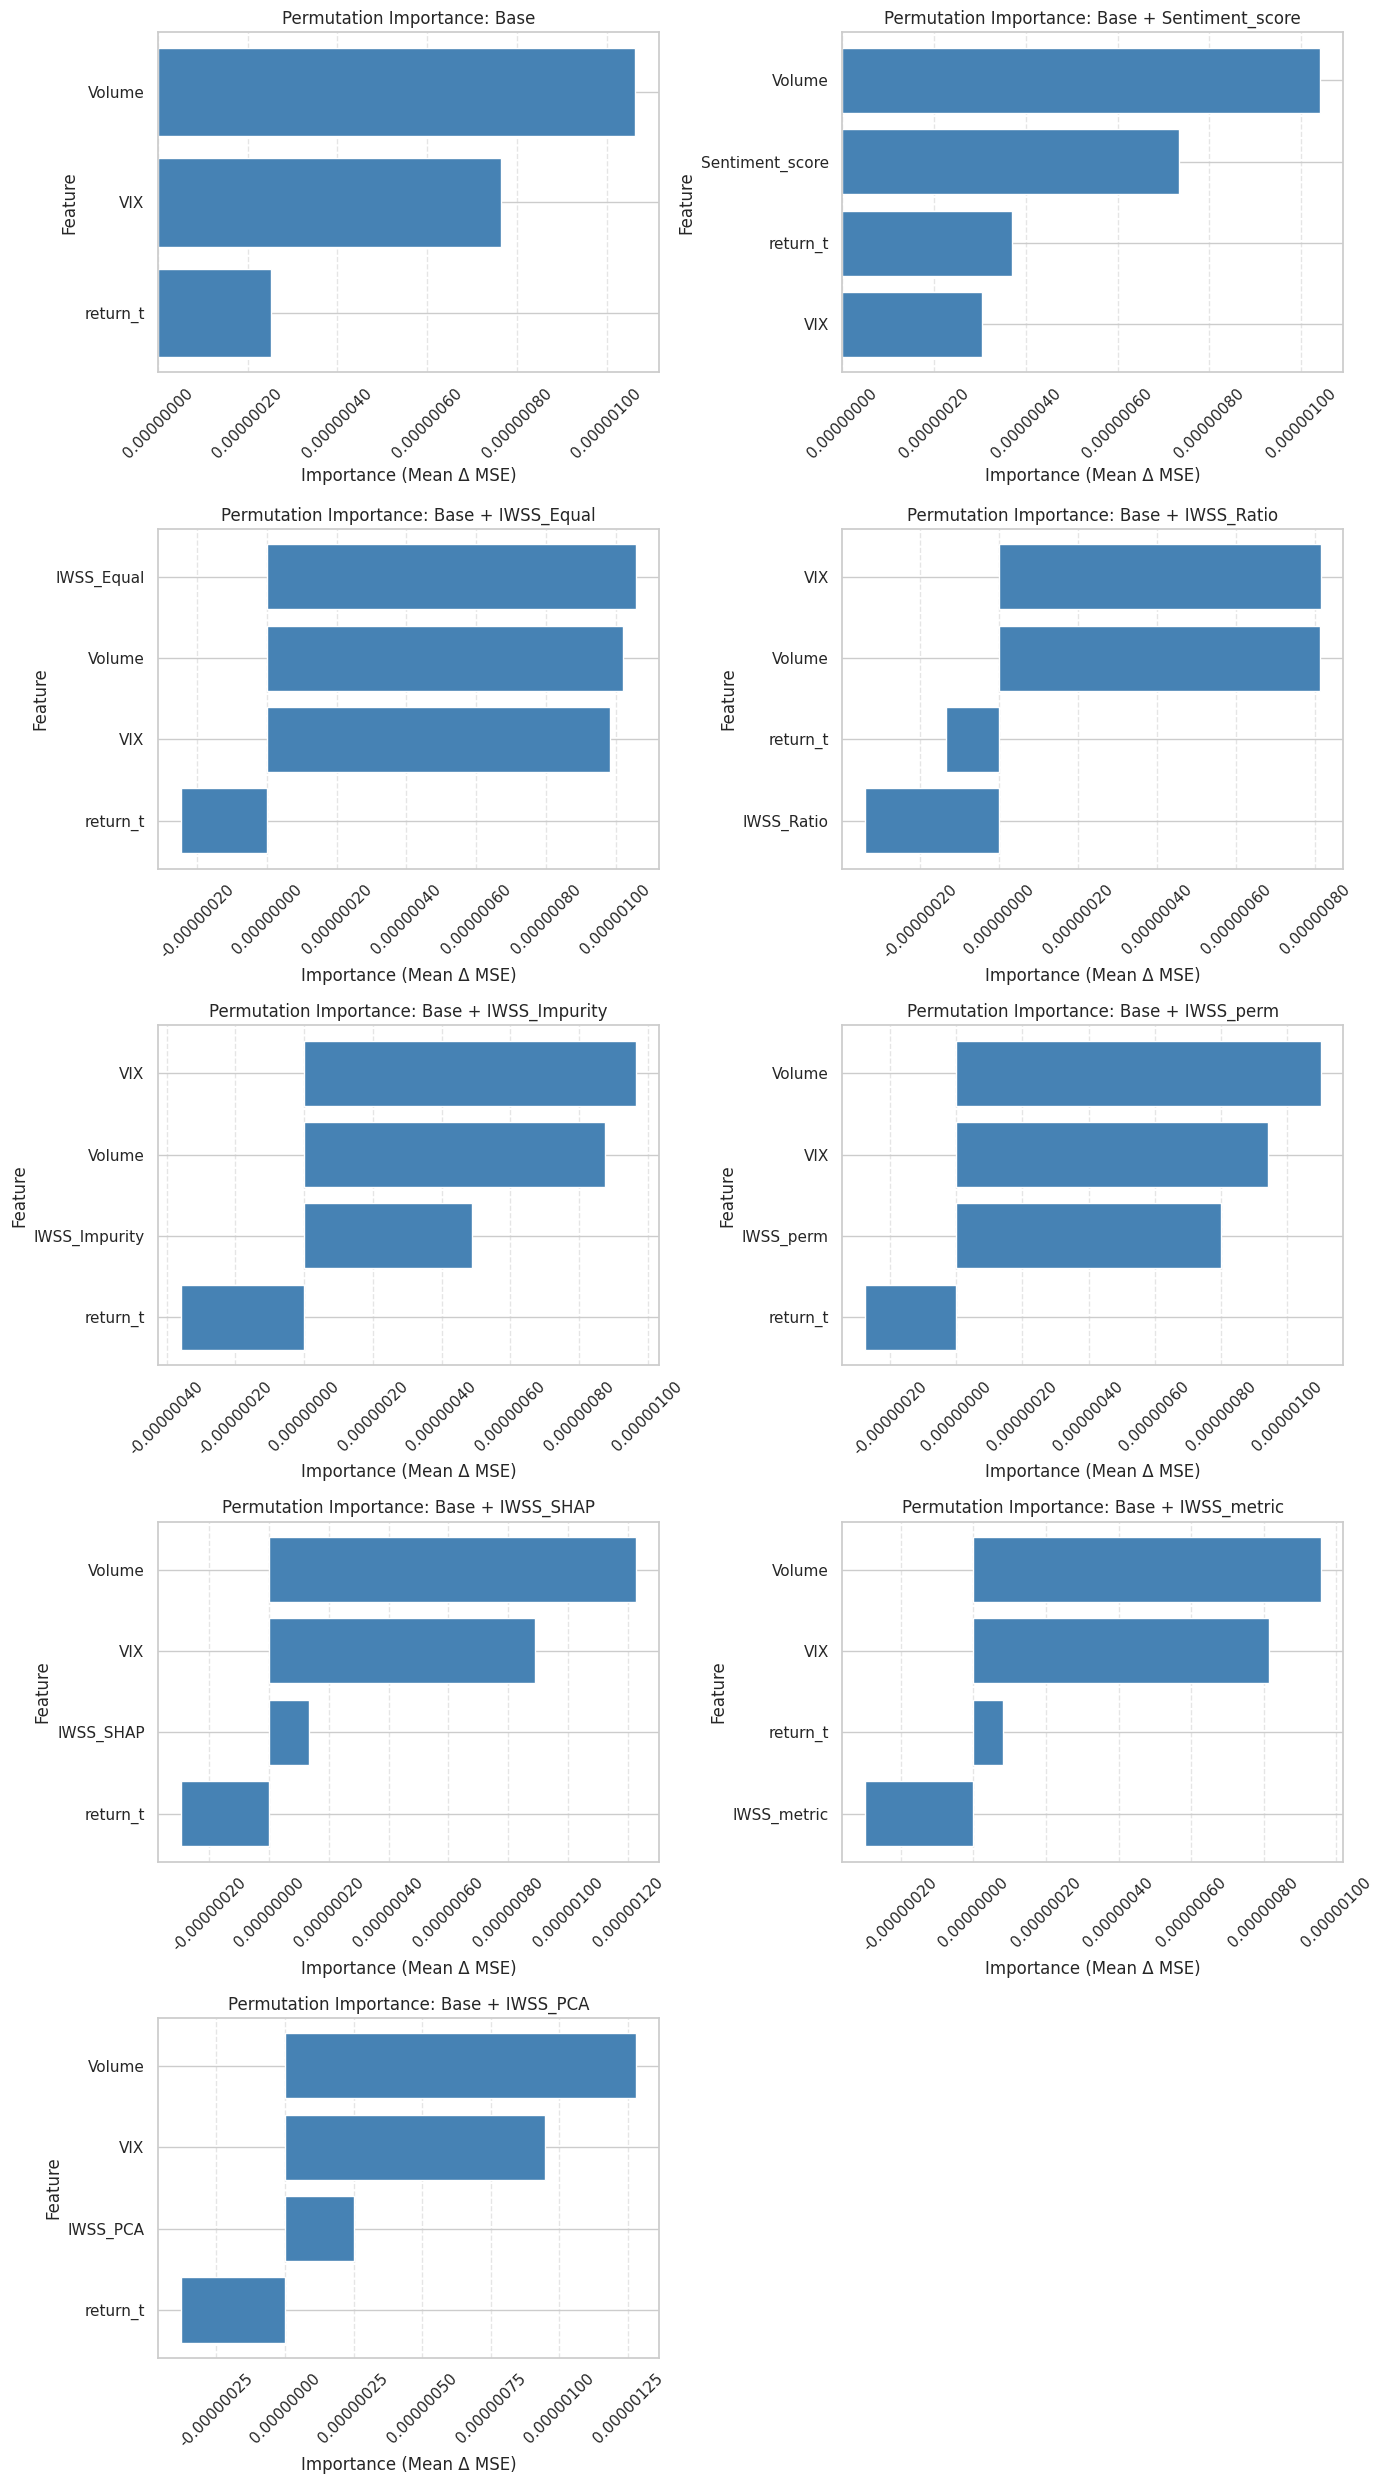

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter to show x-axis in standard decimal notation
def decimal_formatter(x, _):
    return f'{x:.8f}'  # Adjust decimal places here as needed

# Create individual bar charts per model for permutation importance
num_models = len(rf_perm_importance_dict)
fig, axes = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 5 * ((num_models + 1) // 2)))
axes = axes.flatten()

for i, (model_name, importances) in enumerate(rf_perm_importance_dict.items()):
    ax = axes[i]
    sorted_importances = importances.sort_values(ascending=True)
    ax.barh(sorted_importances.index, sorted_importances.values, color='steelblue')
    ax.set_title(f"Permutation Importance: {model_name}", fontsize=12)
    ax.set_xlabel("Importance (Mean Δ MSE)")
    ax.set_ylabel("Feature")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Apply decimal formatting
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

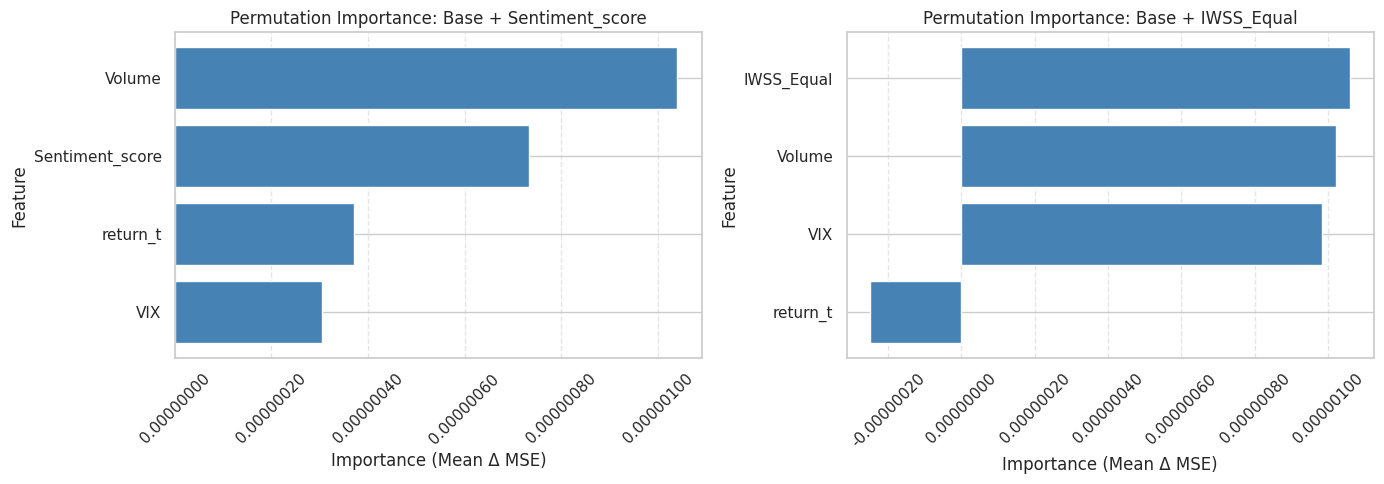

In [ ]:
import matplotlib.pyplot as plt

# Filter models: only include those with 'Sentiment_score' or 'IWSS_Equal' in the name
filtered_importance = {
    name: imp for name, imp in rf_perm_importance_dict.items()
    if 'Sentiment_score' in name or 'IWSS_Equal' in name
}

# Custom formatter to show x-axis in standard decimal notation
def decimal_formatter(x, _):
    return f'{x:.8f}'  # Adjust decimal places here as needed

# Create individual bar charts per model for permutation importance
num_models = len(filtered_importance)
fig, axes = plt.subplots(nrows=(num_models + 1) // 2, ncols=2, figsize=(14, 5 * ((num_models + 1) // 2)))
axes = axes.flatten()

for i, (model_name, importances) in enumerate(filtered_importance.items()):
    ax = axes[i]
    sorted_importances = importances.sort_values(ascending=True)
    ax.barh(sorted_importances.index, sorted_importances.values, color='steelblue')
    ax.set_title(f"Permutation Importance: {model_name}", fontsize=12)
    ax.set_xlabel("Importance (Mean Δ MSE)")
    ax.set_ylabel("Feature")
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    # Apply decimal formatting
    ax.xaxis.set_major_formatter(FuncFormatter(decimal_formatter))
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## DM test

### Based on MSE

In [ ]:
from scipy.stats import ttest_1samp

def diebold_mariano_test(e1, e2, crit='MSE'):
    """
    Diebold-Mariano test comparing two sets of forecast errors.
    e1, e2: forecast errors (arrays of same length)
    crit: 'MSE' or 'MAE'
    """
    e1, e2 = np.asarray(e1), np.asarray(e2)

    if crit == 'MSE':
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)

    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n-1))  # two-sided test

    return dm_stat, p_value

In [ ]:
from scipy import stats

dm_results = []
sentiment_errors = sentiment_errors = forecast_errors['Base + Sentiment_score']


for model_name, errors in forecast_errors.items():
    if model_name in ['Base', 'Base + Sentiment_score']:
        continue

    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')

    dm_results.append({
        'Model Compared': model_name,
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better'
    })

dm_df = pd.DataFrame(dm_results).sort_values('p-value')
dm_df

,Model Compared,DM Statistic,p-value,Interpretation
0,Base + IWSS_Equal,-3.018763,0.002996,IWSS better
3,Base + IWSS_perm,-2.844202,0.005092,IWSS better
6,Base + IWSS_PCA,-2.606548,0.010095,IWSS better
2,Base + IWSS_Impurity,-2.599585,0.010292,IWSS better
4,Base + IWSS_SHAP,-2.471250,0.014614,IWSS better
1,Base + IWSS_Ratio,-2.351493,0.020035,IWSS better
5,Base + IWSS_metric,-2.149970,0.033205,IWSS better


In [ ]:
iwss_models = [name for name in forecast_errors if 'IWSS' in name]

# Compare each IWSS against Sentiment_score
sentiment_errors = forecast_errors['Base + Sentiment_score']
dm_results = []
for model_name in iwss_models:
    errors = forecast_errors[model_name]
    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')
    dm_results.append({
        'Comparison': f'{model_name} vs. Sentiment_score',
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better',
        'Significant': p_value < 0.05
    })

# Compare each IWSS against Base
base_errors = forecast_errors['Base']
for model_name in iwss_models:
    errors = forecast_errors[model_name]
    dm_stat, p_value = diebold_mariano_test(errors, base_errors, crit='MSE')
    dm_results.append({
        'Comparison': f'{model_name} vs. Base',
        'DM Statistic': dm_stat,
        'p-value': p_value,
        'Interpretation': 'Base better' if dm_stat > 0 else 'IWSS better',
        'Significant': p_value < 0.05
    })

# All pairwise IWSS comparisons
for i, model_a in enumerate(iwss_models):
    for model_b in iwss_models[i + 1:]:
        e1 = forecast_errors[model_a]
        e2 = forecast_errors[model_b]
        dm_stat, p_value = diebold_mariano_test(e1, e2, crit='MSE')
        interpretation = f'{model_a} better' if dm_stat > 0 else f'{model_b} better'
        dm_results.append({
            'Comparison': f'{model_a} vs. {model_b}',
            'DM Statistic': dm_stat,
            'p-value': p_value,
            'Interpretation': interpretation,
            'Significant': p_value < 0.05
        })

# Convert to DataFrame and sort
dm_df = pd.DataFrame(dm_results).sort_values('p-value')

In [ ]:
dm_df

,Comparison,DM Statistic,p-value,Interpretation,Significant
0,Base + IWSS_Equal vs. Sentiment_score,-3.018763,0.002996,IWSS better,True
3,Base + IWSS_perm vs. Sentiment_score,-2.844202,0.005092,IWSS better,True
6,Base + IWSS_PCA vs. Sentiment_score,-2.606548,0.010095,IWSS better,True
2,Base + IWSS_Impurity vs. Sentiment_score,-2.599585,0.010292,IWSS better,True
4,Base + IWSS_SHAP vs. Sentiment_score,-2.471250,0.014614,IWSS better,True
1,Base + IWSS_Ratio vs. Sentiment_score,-2.351493,0.020035,IWSS better,True
5,Base + IWSS_metric vs. Sentiment_score,-2.149970,0.033205,IWSS better,True
21,Base + IWSS_Ratio vs. Base + IWSS_perm,2.076152,0.039633,Base + IWSS_Ratio better,True
17,Base + IWSS_Equal vs. Base + IWSS_SHAP,-2.000876,0.047260,Base + IWSS_SHAP better,True
14,Base + IWSS_Equal vs. Base + IWSS_Ratio,-1.877462,0.062450,Base + IWSS_Ratio better,False


### DM with MAE

In [ ]:
def diebold_mariano_test(e1, e2, crit='MAE'):
    """
    Diebold-Mariano test comparing two sets of forecast errors.
    e1, e2: forecast errors (arrays of same length)
    crit: 'MSE' or 'MAE'
    """
    e1, e2 = np.asarray(e1), np.asarray(e2)

    if crit == 'MSE':
        d = (e1 ** 2) - (e2 ** 2)
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("crit must be 'MSE' or 'MAE'")

    mean_d = np.mean(d)
    std_d = np.std(d, ddof=1)
    n = len(d)

    dm_stat = mean_d / (std_d / np.sqrt(n))
    p_value = 2 * (1 - stats.t.cdf(np.abs(dm_stat), df=n-1))  # two-sided test

    return dm_stat, p_value


In [ ]:
from scipy import stats

dm_results_mae = []
sentiment_errors = sentiment_errors = forecast_errors['Base + Sentiment_score']


for model_name, errors in forecast_errors.items():
    if model_name in ['Base', 'Base + Sentiment_score']:
        continue

    dm_stat, p_value = diebold_mariano_test(errors, sentiment_errors, crit='MSE')

    dm_results_mae.append({
        'Model Compared': model_name,
        'DM Statistic (MAE)': dm_stat,
        'p-value (MAE)': p_value,
        'Interpretation': 'Sentiment better' if dm_stat > 0 else 'IWSS better'
    })

dm_df_mae = pd.DataFrame(dm_results_mae).sort_values('p-value (MAE)')
dm_df_mae

,Model Compared,DM Statistic (MAE),p-value (MAE),Interpretation
0,Base + IWSS_Equal,-3.018763,0.002996,IWSS better
3,Base + IWSS_perm,-2.844202,0.005092,IWSS better
6,Base + IWSS_PCA,-2.606548,0.010095,IWSS better
2,Base + IWSS_Impurity,-2.599585,0.010292,IWSS better
4,Base + IWSS_SHAP,-2.471250,0.014614,IWSS better
1,Base + IWSS_Ratio,-2.351493,0.020035,IWSS better
5,Base + IWSS_metric,-2.149970,0.033205,IWSS better


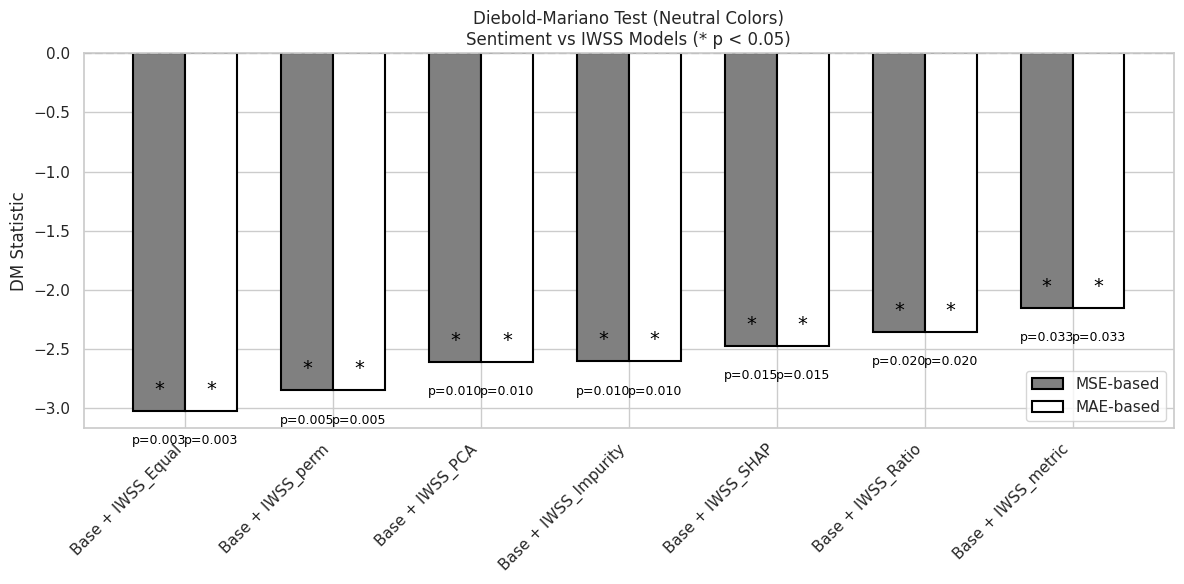

In [ ]:
dm_combined = pd.merge(
    dm_df[['Model Compared', 'DM Statistic', 'p-value']],
    dm_df_mae[['Model Compared', 'DM Statistic (MAE)', 'p-value (MAE)']],
    on='Model Compared'
)

dm_combined_sorted = dm_combined.sort_values(by='DM Statistic')
x = np.arange(len(dm_combined_sorted))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(
    x,
    dm_combined_sorted['DM Statistic'],
    width=bar_width,
    label='MSE-based',
    color='gray',
    edgecolor='black',
    linewidth=1.5
)
bars2 = ax.bar(
    x + bar_width,
    dm_combined_sorted['DM Statistic (MAE)'],
    width=bar_width,
    label='MAE-based',
    color='white',
    edgecolor='black',
    linewidth=1.5
)

# Add significance stars and p-values (MSE)
for i, (p, stat) in enumerate(zip(dm_combined_sorted['p-value'], dm_combined_sorted['DM Statistic'])):
    if p < 0.05:
        ax.text(x[i], stat + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')
    ax.text(x[i], stat - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=9, color='black')

# Add significance stars and p-values (MAE)
for i, (p, stat) in enumerate(zip(dm_combined_sorted['p-value (MAE)'], dm_combined_sorted['DM Statistic (MAE)'])):
    if p < 0.05:
        ax.text(x[i] + bar_width, stat + 0.1, '*', ha='center', va='bottom', fontsize=14, color='black')
    ax.text(x[i] + bar_width, stat - 0.2, f'p={p:.3f}', ha='center', va='top', fontsize=9, color='black')

ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(dm_combined_sorted['Model Compared'], rotation=45, ha='right')
ax.set_ylabel('DM Statistic')
ax.set_title('Diebold-Mariano Test (Neutral Colors)\nSentiment vs IWSS Models (* p < 0.05)')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Store all feature importances
feature_importances = []

for model_name, model in models.items():
    scaler = scalers[model_name]

    # Identify which features were used
    if model_name == 'Base':
        features = base_features
    else:
        sentiment_feat = model_name.replace('Base + ', '')
        features = base_features + [sentiment_feat]

    # Get feature importances from the trained Random Forest
    importances = model.feature_importances_

    # Store in list as dict rows
    for feat, imp in zip(features, importances):
        feature_importances.append({
            'Model': model_name,
            'Feature': feat,
            'Importance': imp
        })

# Convert to DataFrame
importances_df = pd.DataFrame(feature_importances)

# Optional: sort within each model
importances_df = importances_df.sort_values(by=['Model', 'Importance'], ascending=[True, False])

# Display the top feature for each model
top_feats_df = importances_df.groupby('Model').first().reset_index()

# Show full or summarized results
display(importances_df)
display(top_feats_df)


,Model,Feature,Importance
2,Base,VIX,0.347981
1,Base,Volume,0.326350
0,Base,return_t,0.325669
9,Base + IWSS_Equal,VIX,0.269269
10,Base + IWSS_Equal,IWSS_Equal,0.254100
7,Base + IWSS_Equal,return_t,0.250501
8,Base + IWSS_Equal,Volume,0.226130
17,Base + IWSS_Impurity,VIX,0.284936
15,Base + IWSS_Impurity,return_t,0.266611
16,Base + IWSS_Impurity,Volume,0.239438


,Model,Feature,Importance
0,Base,VIX,0.347981
1,Base + IWSS_Equal,VIX,0.269269
2,Base + IWSS_Impurity,VIX,0.284936
3,Base + IWSS_PCA,VIX,0.323894
4,Base + IWSS_Ratio,VIX,0.291927
5,Base + IWSS_SHAP,VIX,0.315763
6,Base + IWSS_metric,VIX,0.345325
7,Base + IWSS_perm,VIX,0.270054
8,Base + Sentiment_score,Sentiment_score,0.329478


note, these are MDI importance, Bias toward high-cardinality features (those with many unique values).

Doesn’t show whether the relationship is positive or negative.

Doesn’t capture interactions unless you look into SHAP or permutation importance.



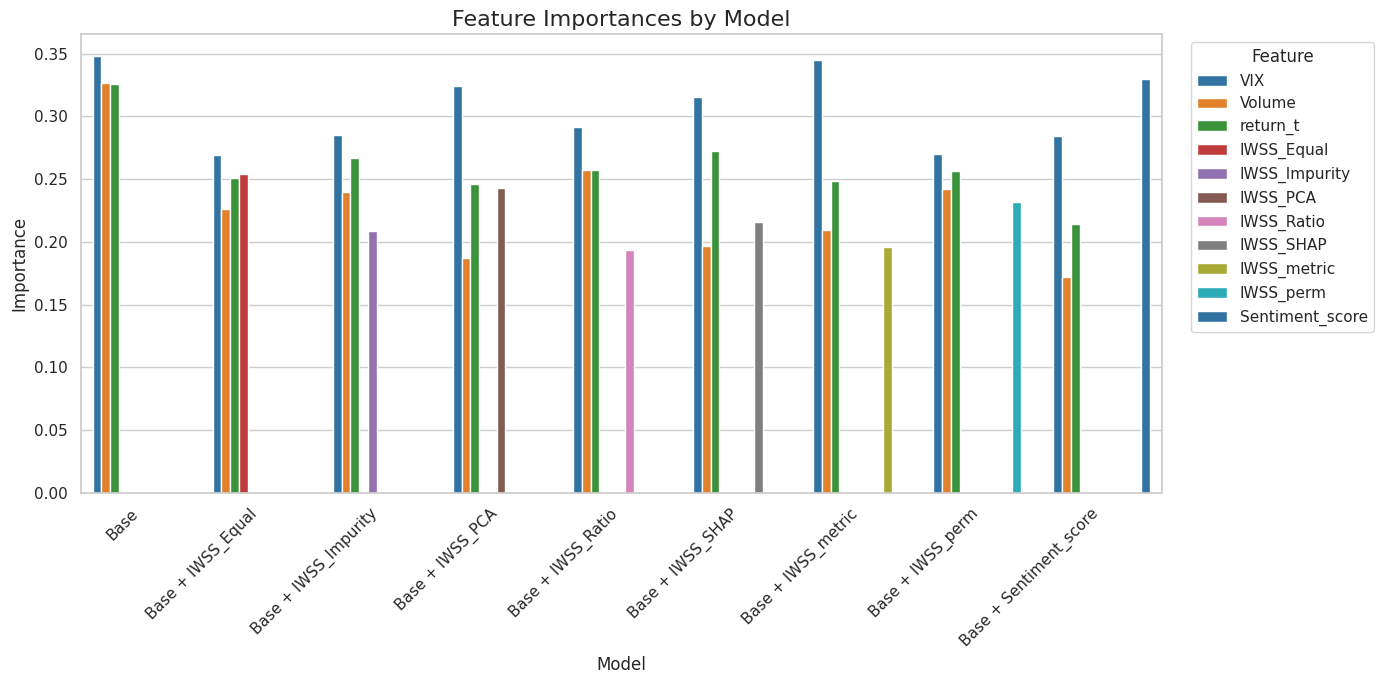

In [ ]:
# Base setup
plt.figure(figsize=(14, 7))

# Use consistent ordering for models
order = importances_df['Model'].unique()

# Plot: Models on x-axis, grouped by Feature
sns.barplot(
    data=importances_df,
    x='Model',
    y='Importance',
    hue='Feature',
    order=order,
    palette='tab10'  # Or 'Set2', 'pastel', etc.
)

# Make it readable
plt.title("Feature Importances by Model", fontsize=16)
plt.ylabel("Importance", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-73-1c75567f0fef>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_df, x='Model', y='Importance', palette='muted')


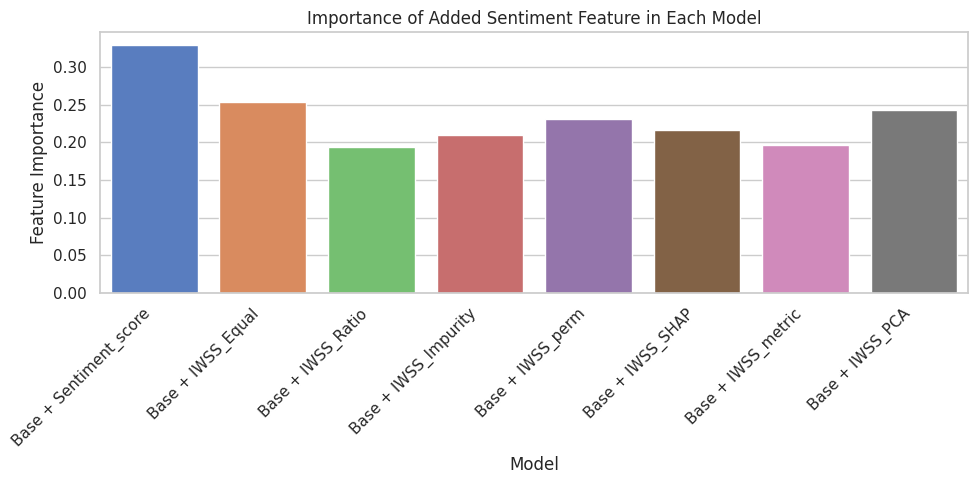

In [ ]:
# Importance of ssentiment added feature
sentiment_importances = []

for model_name, model in models.items():
    if model_name == 'Base':
        continue  # Skip base model

    sentiment_feat = model_name.replace('Base + ', '')

    # Find the importance value for that feature in this model
    for row in feature_importances:
        if row['Model'] == model_name and row['Feature'] == sentiment_feat:
            sentiment_importances.append({
                'Model': model_name,
                'Sentiment Feature': sentiment_feat,
                'Importance': row['Importance']
            })
            break  # Found the feature, no need to keep looping

sentiment_df = pd.DataFrame(sentiment_importances)

plt.figure(figsize=(10, 5))
sns.barplot(data=sentiment_df, x='Model', y='Importance', palette='muted')
plt.title("Importance of Added Sentiment Feature in Each Model")
plt.ylabel("Feature Importance")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


How valuable each specific sentiment/IWSS feature was in its model

In [ ]:
test_df = pd.DataFrame(test_results)
test_df.sort_values(by='ROOS', ascending=False, inplace=True)

In [ ]:
sentiment_importances = []

for model_name, model in models.items():
    if model_name == 'Base':
        continue  # skip base model (no added sentiment feature)

    sentiment_feat = model_name.replace('Base + ', '')

    # Get the importance and rank of the sentiment feature
    model_importances = [row for row in feature_importances if row['Model'] == model_name]
    model_importances_sorted = sorted(model_importances, key=lambda x: x['Importance'], reverse=True)

    for rank, row in enumerate(model_importances_sorted, 1):
        if row['Feature'] == sentiment_feat:
            sentiment_importances.append({
                'Model': model_name,
                'Sentiment Feature': sentiment_feat,
                'Importance': row['Importance'],
                'Rank in Model': rank
            })
            break

sentiment_df = pd.DataFrame(sentiment_importances)

sentiment_df = sentiment_df.merge(test_df[['Model', 'ROOS']], on='Model', how='left')


In [ ]:
# Rank of Sentiment Feature in Each Model

display(sentiment_df[['Model', 'Sentiment Feature', 'Importance', 'Rank in Model']].sort_values('Rank in Model'))



,Model,Sentiment Feature,Importance,Rank in Model
0,Base + Sentiment_score,Sentiment_score,0.329478,1
1,Base + IWSS_Equal,IWSS_Equal,0.254100,2
7,Base + IWSS_PCA,IWSS_PCA,0.242941,3
5,Base + IWSS_SHAP,IWSS_SHAP,0.215642,3
3,Base + IWSS_Impurity,IWSS_Impurity,0.209015,4
2,Base + IWSS_Ratio,IWSS_Ratio,0.193423,4
4,Base + IWSS_perm,IWSS_perm,0.231479,4
6,Base + IWSS_metric,IWSS_metric,0.196283,4


<ipython-input-88-df2475a4190d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compare_df, x='Sentiment Feature', y='ROOS', palette='viridis')


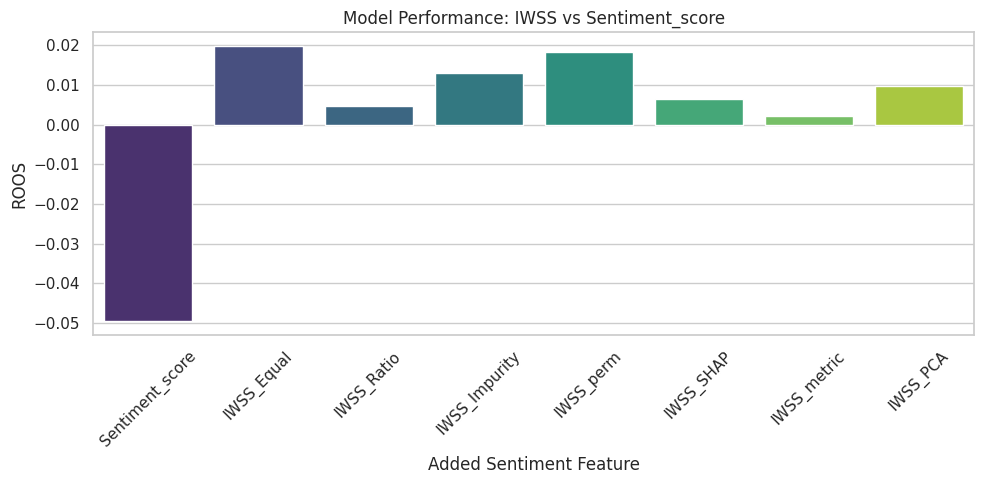

In [ ]:
plt.figure(figsize=(10, 5))
compare_df = sentiment_df[sentiment_df['Sentiment Feature'].str.startswith('IWSS') |
                          (sentiment_df['Sentiment Feature'] == 'Sentiment_score')]

sns.barplot(data=compare_df, x='Sentiment Feature', y='ROOS', palette='viridis')
plt.title("Model Performance: IWSS vs Sentiment_score")
plt.ylabel("ROOS")
plt.xlabel("Added Sentiment Feature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

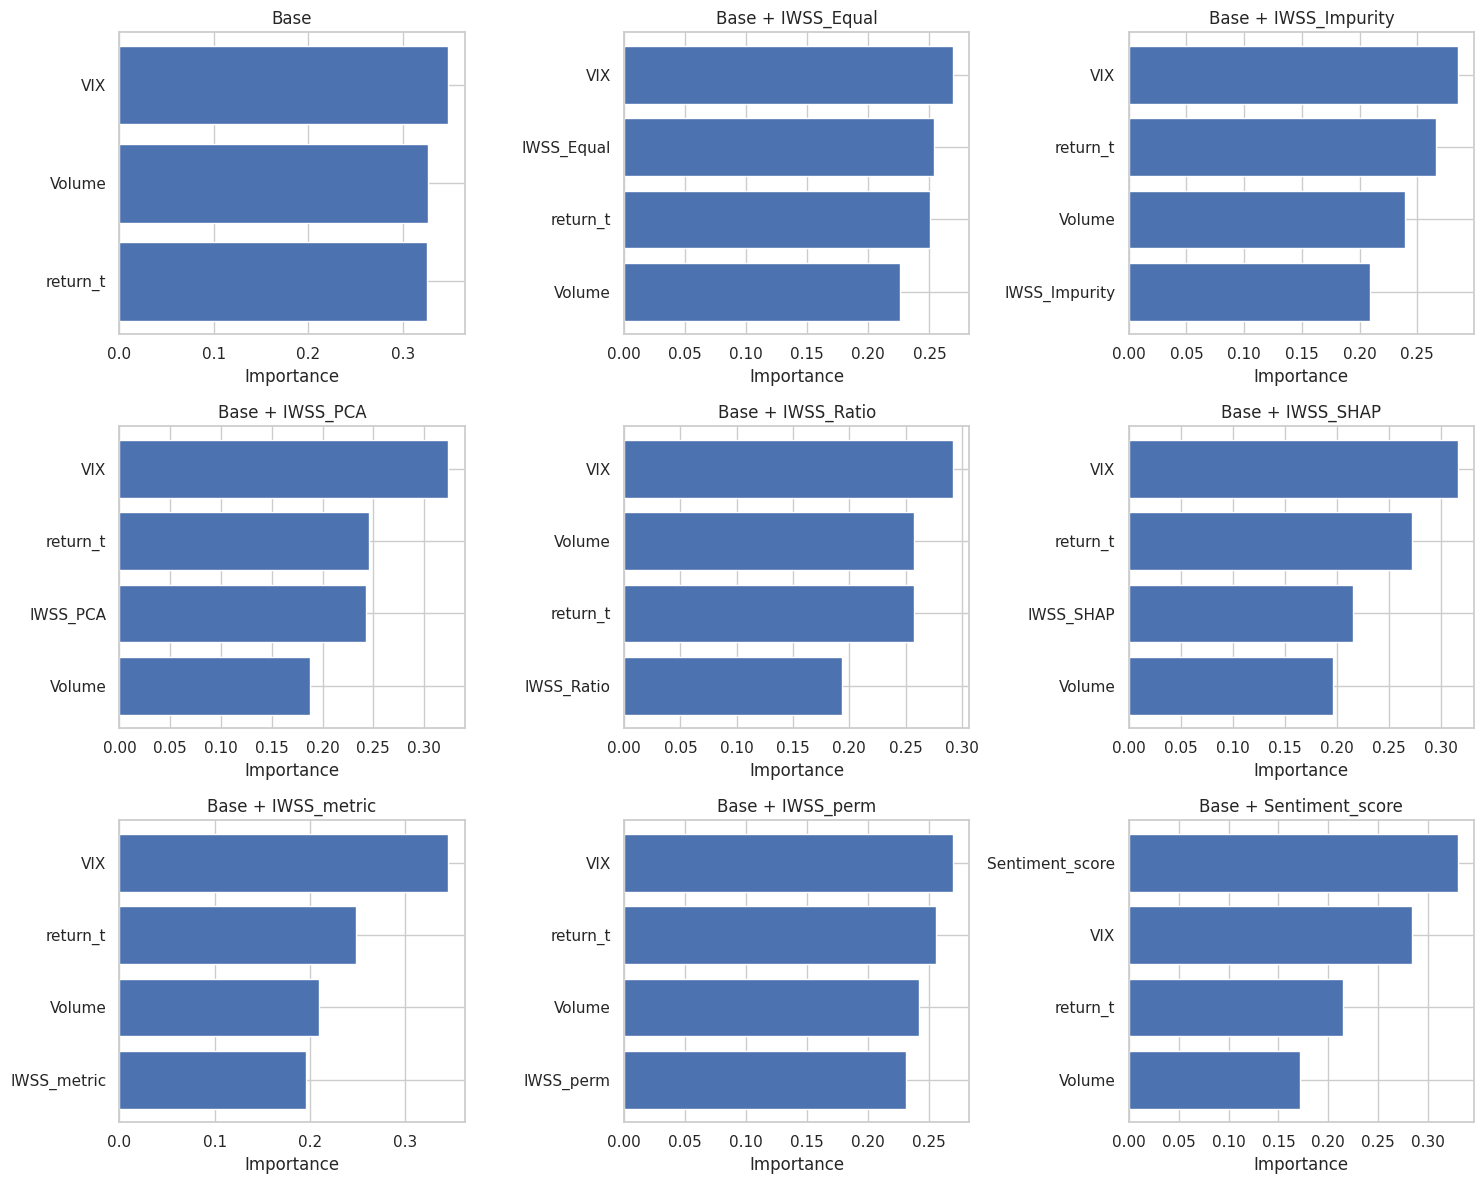

In [ ]:
import matplotlib.pyplot as plt

unique_models = importances_df['Model'].unique()

n_models = len(unique_models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axs = axs.flatten()

for idx, model_name in enumerate(unique_models):
    ax = axs[idx]
    plot_df = importances_df[importances_df['Model'] == model_name].sort_values(by='Importance', ascending=True)

    ax.barh(plot_df['Feature'], plot_df['Importance'])
    ax.set_title(model_name)
    ax.set_xlabel('Importance')

# Remove empty plots if any
for j in range(idx + 1, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()


In [ ]:
actual_vs_predicted_tables = {}

for model_name, model in models.items():
    scaler = scalers[model_name]

    # Determine which features were used in this model
    if model_name == 'Base':
        features = base_features
    else:
        added_feat = model_name.replace('Base + ', '')
        features = base_features + [added_feat]

    # Scale test features
    X_test_scaled = scaler.transform(df_test[features])

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Store actual vs predicted
    actual_vs_predicted_tables[model_name] = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': y_pred
    })